In [1]:
# --- 1. Impor Semua Library yang Dibutuhkan ---
import pandas as pd
import numpy as np
import lightgbm as lgb
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import os

In [13]:
# --- 2. Memuat Data Latih dan Uji yang Sudah Dibagi ---
path_split_data = r'C:\MyFolder\Git\TA_SpatioTemporal\Data\split_data'

# --- Path BARU untuk data spasial ---
path_train = os.path.join(path_split_data, 'train_set_spatial.parquet')
path_test = os.path.join(path_split_data, 'test_set_spatial.parquet')

# Memuat data ke DataFrame
train_set = pd.read_parquet(path_train)
test_set = pd.read_parquet(path_test)

print("Data latih dan uji berhasil dimuat.")

# --- 3. Mempersiapkan Fitur dan Target (DENGAN PERBAIKAN FINAL) ---
TARGET = 'konsumsi_energi'

# Dapatkan semua kolom kecuali timestamp dan target
FEATURES = [col for col in train_set.columns if col not in ['timestamp', TARGET]]

# --- PERBAIKAN UNTUK VALUEERROR ---
# Secara eksplisit hapus kolom 'koordinat' yang bertipe object dari daftar fitur.
# Kolom ini masuk saat merge dengan file excel dan tidak diperlukan untuk model.
if 'koordinat' in FEATURES:
    FEATURES.remove('koordinat')
    print("Kolom 'koordinat' (tipe object) telah dihapus dari daftar fitur.")
# --------------------------------

# Ubah tipe data 'meter_id' ke 'category' agar LightGBM menanganinya dengan benar
train_set['meter_id'] = train_set['meter_id'].astype('category')
test_set['meter_id'] = test_set['meter_id'].astype('category')

# Buat set X (fitur) dan y (target)
X_train = train_set[FEATURES]
y_train = train_set[TARGET]
X_test = test_set[FEATURES]
y_test = test_set[TARGET]

print(f"\nJumlah data Latih: {len(X_train)}")
print(f"Jumlah data Uji: {len(X_test)}")
print(f"Jumlah Fitur: {len(FEATURES)}")
print("Contoh fitur yang digunakan:", FEATURES[:5])

Data latih dan uji berhasil dimuat.
Kolom 'koordinat' (tipe object) telah dihapus dari daftar fitur.

Jumlah data Latih: 276222
Jumlah data Uji: 47234
Jumlah Fitur: 20
Contoh fitur yang digunakan: ['meter_id', 'is_kelas', 'is_kantor', 'is_penelitian', 'avg_temp_previous_hour']


In [14]:
# Melatih Model LightGBM

# Inisialisasi model. Parameter ini adalah titik awal yang bagus.
model = lgb.LGBMRegressor(
    objective='regression_l1', # Mengoptimalkan untuk MAE
    n_estimators=1000,         # Jumlah pohon yang akan dibuat
    learning_rate=0.05,
    num_leaves=31,
    n_jobs=-1,                 # Menggunakan semua core CPU
    seed=42
)

print("\nMulai melatih model LightGBM...")

# Latih model dengan data latih.
# eval_set memungkinkan kita memantau performa model pada data uji di setiap tahap.
model.fit(X_train, y_train,
          eval_set=[(X_test, y_test)],
          eval_metric='mae',
          callbacks=[lgb.early_stopping(100, verbose=True)]) # Berhenti jika performa tidak membaik setelah 100 iterasi

print("\nModel berhasil dilatih!")



Mulai melatih model LightGBM...
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.014860 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1564
[LightGBM] [Info] Number of data points in the train set: 276222, number of used features: 20
[LightGBM] [Info] Start training from score 14.325450
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[1000]	valid_0's l1: 1.64168

Model berhasil dilatih!


In [15]:
# --- 4. Evaluasi Model ---

# Fungsi untuk menghitung sMAPE yang lebih stabil
def calculate_smape(y_true, y_pred):
    """Menghitung Symmetric Mean Absolute Percentage Error (sMAPE)"""
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    
    # Hitung pembilang dan penyebut
    numerator = np.abs(y_pred - y_true)
    denominator = (np.abs(y_true) + np.abs(y_pred)) / 2
    
    # Hindari pembagian dengan nol jika keduanya (aktual & prediksi) adalah nol
    ratio = np.divide(numerator, denominator, out=np.zeros_like(denominator), where=denominator!=0)
    
    return np.mean(ratio) * 100

# Buat prediksi pada data uji
predictions = model.predict(X_test)

# Hitung metrik evaluasi
mae = mean_absolute_error(y_test, predictions)
rmse = np.sqrt(mean_squared_error(y_test, predictions))
r2 = r2_score(y_test, predictions)
smape = calculate_smape(y_test, predictions) # Hitung sMAPE

print("\n--- Hasil Evaluasi Model (Komprehensif) ---")
print(f"Mean Absolute Error (MAE): {mae:.2f}")
print(f"Root Mean Square Error (RMSE): {rmse:.2f}")
print(f"Symmetric Mean Absolute Percentage Error (sMAPE): {smape:.2f}%")
print(f"R-squared (R²): {r2:.2f}")

print("\nInterpretasi:")
print(f"- Rata-rata, prediksi model meleset sebesar {mae:.2f} kWh dari nilai sebenarnya.")
print(f"- Rata-rata, persentase kesalahan prediksi (sMAPE) adalah {smape:.2f}%.")
print(f"- Model dapat menjelaskan sekitar {r2:.0%} dari variasi konsumsi energi.")



--- Hasil Evaluasi Model (Komprehensif) ---
Mean Absolute Error (MAE): 1.64
Root Mean Square Error (RMSE): 4.24
Symmetric Mean Absolute Percentage Error (sMAPE): 10.33%
R-squared (R²): 0.98

Interpretasi:
- Rata-rata, prediksi model meleset sebesar 1.64 kWh dari nilai sebenarnya.
- Rata-rata, persentase kesalahan prediksi (sMAPE) adalah 10.33%.
- Model dapat menjelaskan sekitar 98% dari variasi konsumsi energi.


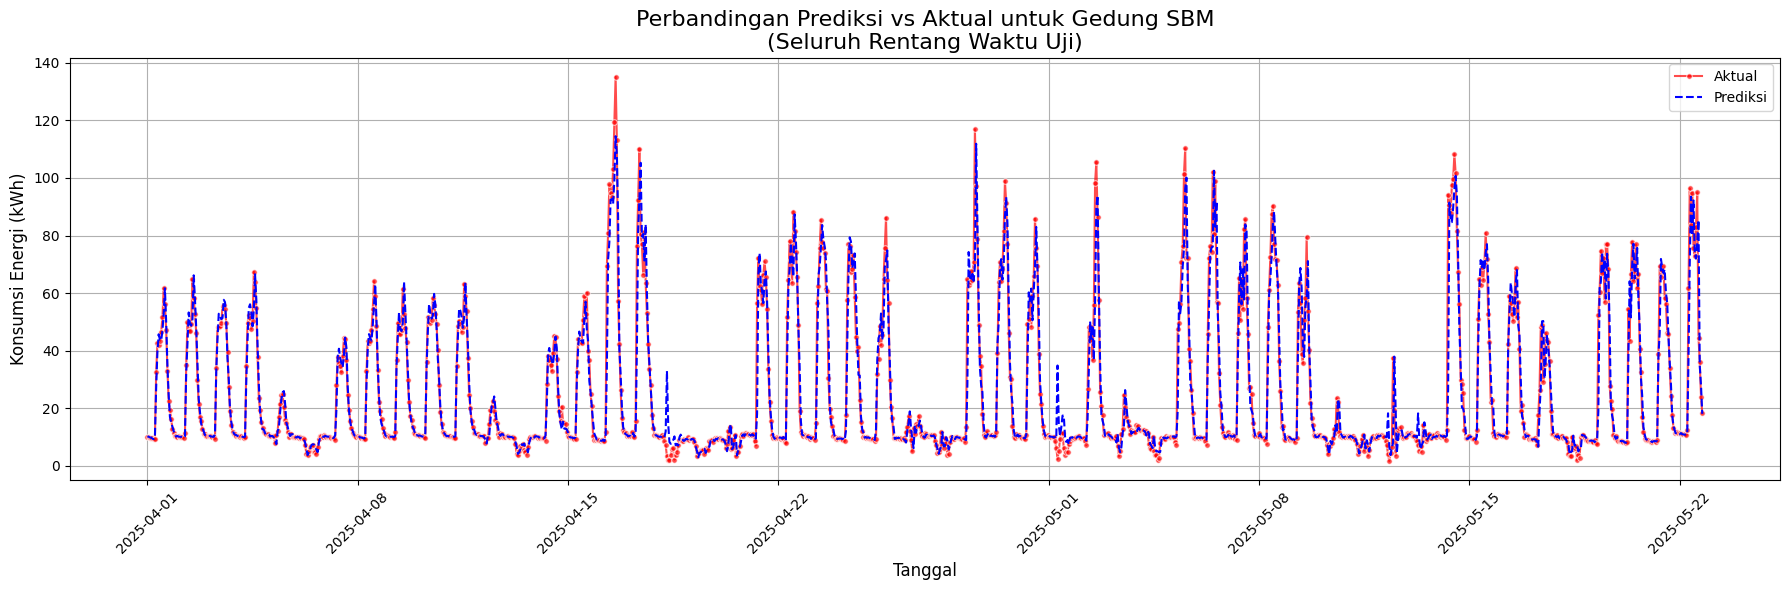

<Figure size 1200x800 with 0 Axes>

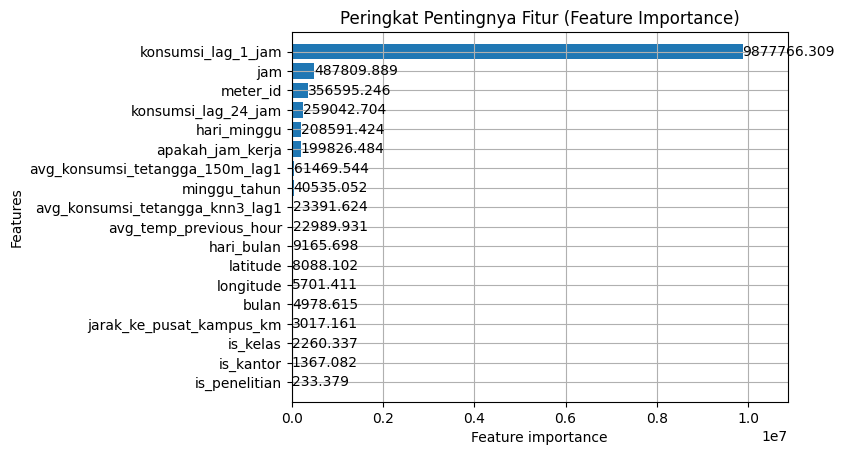

In [16]:
# --- 5. Visualisasi Hasil ---

from mydef import plot_prediksi_vs_aktual
# --- Menggunakan Fungsi Visualisasi ---
# 1. Siapkan DataFrame hasil
results = X_test.copy()
results['target_aktual'] = y_test
results['prediksi'] = predictions
results['timestamp'] = pd.to_datetime(test_set['timestamp'])

# 2. Panggil fungsi untuk melihat hasil (Anda bisa mengubah parameter ini)
plot_prediksi_vs_aktual(results, meter_id_to_plot='SBM', start_date_str='all', end_date_str='all')
# plot_prediksi_vs_aktual(results, meter_id_to_plot='SBM', start_date_str='2025-04-01', end_date_str='2025-04-08')

# CONTOH 2: Melihat satu gedung spesifik untuk SELURUH rentang waktu uji
# plot_prediksi_vs_aktual(results, meter_id_to_plot='CAS', start_date_str='all', end_date_str='all')

# CONTOH 3: Melihat SEMUA gedung untuk 3 hari pertama (akan menghasilkan banyak plot)
# plot_prediksi_vs_aktual(results, meter_id_to_plot='all', start_date_str='2025-04-01', end_date_str='2025-04-03')


# 3. Plot Pentingnya Fitur (tetap sama)
plt.figure(figsize=(12, 8))
lgb.plot_importance(model, importance_type='gain', max_num_features=20, height=0.8)
plt.title('Peringkat Pentingnya Fitur (Feature Importance)')
plt.show()

In [17]:
# --- Tambahkan kode ini di akhir notebook LightGBM ---

# Definisikan path untuk menyimpan file
path_output = r'C:\MyFolder\Git\TA_SpatioTemporal\Data\predictions'
os.makedirs(path_output, exist_ok=True) # Membuat folder jika belum ada

# Variabel yang perlu disimpan adalah 'results' DataFrame dari Langkah 3.E
# DataFrame ini sudah berisi semua informasi yang kita butuhkan.
# Kita hanya perlu mengganti nama kolom prediksi agar spesifik untuk model ini.
results_lgbm_to_save = results.rename(columns={'prediksi': 'prediksi_lgbm'})

# Simpan DataFrame hasil yang sudah lengkap
# --- Nama file output BARU ---
nama_file_output = 'lgbm_results_spatial.parquet'
results_lgbm_to_save.to_parquet(os.path.join(path_output, nama_file_output), index=False)

print("\nBerhasil menyimpan hasil lengkap LightGBM (termasuk data aktual dan prediksi).")



Berhasil menyimpan hasil lengkap LightGBM (termasuk data aktual dan prediksi).
